In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## download covid dataset

In [2]:
!wget https://covid.ourworldindata.org/data/owid-covid-data.csv

--2021-11-09 07:20:17--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.137, 104.21.233.138, 2606:4700:3038::6815:e98a, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘owid-covid-data.csv.3’

owid-covid-data.csv     [  <=>               ]  34.47M   162MB/s    in 0.2s    

2021-11-09 07:20:17 (162 MB/s) - ‘owid-covid-data.csv.3’ saved [36149878]



## read covid dataset and drop per million

In [3]:
df = pd.read_csv('owid-covid-data.csv')

drop_per_million_list = [
    'total_cases_per_million',
    'new_cases_per_million',
    'new_cases_smoothed_per_million',
    'total_deaths_per_million',
    'new_deaths_per_million',
    'new_deaths_smoothed_per_million',
    'icu_patients_per_million',
    'hosp_patients_per_million',
    'weekly_icu_admissions_per_million',
    'weekly_hosp_admissions_per_million',
    'new_vaccinations_smoothed_per_million',
    'excess_mortality_cumulative_per_million'
]
df.drop(drop_per_million_list, axis=1, inplace=True)

df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,icu_patients,hosp_patients,weekly_icu_admissions,weekly_hosp_admissions,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN


## plot case, death and vaccinated over time

In [4]:
!pip install persiantools

In [5]:
from persiantools.jdatetime import JalaliDate

def convert_date(date_str):
  year, month, day = date_str.split('-')
  year_int, month_int, day_int = int(year), int(month), int(day) 
  return JalaliDate.to_jalali(year_int, month_int, day_int)

df_ir = df.copy(deep=True)
df_ir.date = df.date.apply(convert_date)

- 1-8 is in first week of a month, we show sum of casses in 8th day of month
- 9-16 is in secont week of a month, we show sum of casses in 16th day of month
- 17-24 is in 3th week of a month, we show sum of casses in 24th day of month
- 25-end is in 4th week of a month, we show sum of casses in 29th day of month


In [6]:
def find_week_date(date_jal):
  if date_jal.day >= 1 and date_jal.day <= 8:
    return JalaliDate(date_jal.year, date_jal.month, 8).to_gregorian() 
  elif date_jal.day >= 9 and date_jal.day <= 16:
    return JalaliDate(date_jal.year, date_jal.month, 16).to_gregorian() 
  elif date_jal.day >= 17 and date_jal.day <= 24:
    return JalaliDate(date_jal.year, date_jal.month, 24).to_gregorian() 
  else:
    return JalaliDate(date_jal.year, date_jal.month, 29).to_gregorian() 


In [7]:
def short_date(in_str):
  return in_str[:7]

In [8]:
df_ir = df_ir[df_ir['location'] == 'Iran']
df_ir['week'] = df_ir.date.apply(find_week_date)
df_ir_per_week = df_ir.groupby('week').sum()
# df_ir_per_week.index = pd.to_datetime(df_ir_per_week.index)
df_ir_per_week = df_ir_per_week.reset_index()
df_ir_per_week.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,week,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,icu_patients,hosp_patients,weekly_icu_admissions,weekly_hosp_admissions,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality
0,2020-02-18,2.0,2.0,0.000,2.0,2.0,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,85028760.0,49.831,32.4,5.44,3.182,19082.62,0.2,270.308,9.59,0.8,21.1,0.0,1.5,76.68,0.783,0.0,0.00,0.00
1,2020-02-27,634.0,243.0,76.142,92.0,24.0,9.858,4.88,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.74,680230080.0,398.648,259.2,43.52,25.456,152660.96,1.6,2162.464,76.72,6.4,168.8,0.0,12.0,613.44,6.264,-2658.0,-4.14,2.79
2,2020-03-06,16978.0,4502.0,2280.141,597.0,98.0,67.571,30.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.40,680230080.0,398.648,259.2,43.52,25.456,152660.96,1.6,2162.464,76.72,6.4,168.8,0.0,12.0,613.44,6.264,-2459.5,-3.42,2.58
3,2020-03-14,70760.0,7982.0,6906.715,2775.0,487.0,295.285,12.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,362.96,680230080.0,398.648,259.2,43.52,25.456,152660.96,1.6,2162.464,76.72,6.4,168.8,0.0,12.0,613.44,6.264,-1414.9,-1.78,13.58
4,2020-03-19,80866.0,5678.0,5717.429,4984.0,673.0,496.999,6.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,244.45,425143800.0,249.155,162.0,27.20,15.910,95413.10,1.0,1351.540,47.95,4.0,105.5,0.0,7.5,383.40,3.915,1316.2,1.52,38.28


### fill nan in new vaccination

- Due to the lack of regular daily announcement of vaccination statistics in some countries, such as Iran, there is a large number of nan in the new_vaccination column.

- To solve this problem, we use the new_vaccinations_smoothed for each day. The sum of these daily amounts gives us the total number of new vaccines injected per week. The new_vaccinations_smoothed after the start of vaccination no longer has the amount of nan.

In [9]:
df_ir.isna().sum()

iso_code                                  0
continent                                 0
location                                  0
date                                      0
total_cases                               0
new_cases                                 0
new_cases_smoothed                        5
total_deaths                              0
new_deaths                                0
new_deaths_smoothed                       5
reproduction_rate                        11
icu_patients                            629
hosp_patients                           629
weekly_icu_admissions                   629
weekly_hosp_admissions                  629
new_tests                               389
total_tests                             273
total_tests_per_thousand                273
new_tests_per_thousand                  389
new_tests_smoothed                       57
new_tests_smoothed_per_thousand          57
positive_rate                            57
tests_per_case                  

In [10]:
(df_ir.dropna(subset=['new_vaccinations_smoothed']))

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,icu_patients,hosp_patients,weekly_icu_admissions,weekly_hosp_admissions,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,week
56298,IRN,Asia,Iran,1399-11-21,1481396.0,7640.0,7140.000,58625.0,89.0,73.571,1.08,NaN,NaN,NaN,NaN,NaN,9779202.0,115.011,NaN,54891.0,0.646,0.130,7.7,tests performed,3000.0,3000.0,NaN,NaN,3000.0,3000.0,0.00,0.00,NaN,NaN,80.09,85028760.0,49.831,32.4,5.44,3.182,19082.62,0.2,270.308,9.59,0.8,21.1,NaN,1.5,76.68,0.783,NaN,NaN,NaN,2021-02-12
56299,IRN,Asia,Iran,1399-11-22,1488981.0,7585.0,7242.143,58686.0,61.0,71.000,1.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54700.0,0.643,0.132,7.6,tests performed,NaN,NaN,NaN,NaN,NaN,1938.0,NaN,NaN,NaN,NaN,80.09,85028760.0,49.831,32.4,5.44,3.182,19082.62,0.2,270.308,9.59,0.8,21.1,NaN,1.5,76.68,0.783,NaN,NaN,NaN,2021-02-12
56300,IRN,Asia,Iran,1399-11-23,1496455.0,7474.0,7304.143,58751.0,65.0,70.714,1.05,NaN,NaN,NaN,NaN,NaN,9885913.0,116.266,NaN,54426.0,0.640,0.134,7.5,tests performed,NaN,NaN,NaN,NaN,NaN,1583.0,NaN,NaN,NaN,NaN,80.09,85028760.0,49.831,32.4,5.44,3.182,19082.62,0.2,270.308,9.59,0.8,21.1,NaN,1.5,76.68,0.783,NaN,NaN,NaN,2021-02-12
56301,IRN,Asia,Iran,1399-11-24,1503753.0,7298.0,7339.000,58809.0,58.0,67.571,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54456.0,0.640,0.135,7.4,tests performed,NaN,NaN,NaN,NaN,NaN,1406.0,NaN,NaN,NaN,NaN,80.09,85028760.0,49.831,32.4,5.44,3.182,19082.62,0.2,270.308,9.59,0.8,21.1,NaN,1.5,76.68,0.783,NaN,NaN,NaN,2021-02-12
56302,IRN,Asia,Iran,1399-11-25,1510873.0,7120.0,7357.571,58883.0,74.0,67.286,1.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54486.0,0.641,0.135,7.4,tests performed,NaN,NaN,NaN,NaN,NaN,1300.0,NaN,NaN,NaN,NaN,80.09,85028760.0,49.831,32.4,5.44,3.182,19082.62,0.2,270.308,9.59,0.8,21.1,NaN,1.5,76.68,0.783,NaN,NaN,NaN,2021-02-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56563,IRN,Asia,Iran,1400-08-10,5934495.0,9857.0,9447.857,126456.0,153.0,156.143,0.95,NaN,NaN,NaN,NaN,NaN,35620381.0,418.922,NaN,107605.0,1.266,0.088,11.4,tests performed,NaN,NaN,NaN,NaN,NaN,989016.0,NaN,NaN,NaN,NaN,NaN,85028760.0,49.831,32.4,5.44,3.182,19082.62,0.2,270.308,9.59,0.8,21.1,NaN,1.5,76.68,0.783,NaN,NaN,NaN,2021-11-07
56564,IRN,Asia,Iran,1400-08-11,5944599.0,10104.0,9591.857,126616.0,160.0,156.714,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108214.0,1.273,0.089,11.3,tests performed,89255211.0,53102837.0,36054893.0,97481.0,NaN,984593.0,104.97,62.45,42.40,0.11,NaN,85028760.0,49.831,32.4,5.44,3.182,19082.62,0.2,270.308,9.59,0.8,21.1,NaN,1.5,76.68,0.783,NaN,NaN,NaN,2021-11-07
56565,IRN,Asia,Iran,1400-08-12,5954962.0,10363.0,9551.714,126763.0,147.0,149.571,0.95,NaN,NaN,NaN,NaN,NaN,35834817.0,421.443,NaN,107925.0,1.269,0.089,11.3,tests performed,NaN,NaN,NaN,NaN,NaN,1004387.0,NaN,NaN,NaN,NaN,NaN,85028760.0,49.831,32.4,5.44,3.182,19082.62,0.2,270.308,9.59,0.8,21.1,NaN,1.5,76.68,0.783,NaN,NaN,NaN,2021-11-07
56566,IRN,Asia,Iran,1400-08-13,5964824.0,9862.0,9330.714,126921.0,158.0,149.429,0.93,NaN,NaN,NaN,NaN,112062.0,35946879.0,422.761,1.318,108466.0,1.276,0.086,11.6,tests performed,N

In [11]:
def diff_end_marker_need(day):
  if day >= 1 and day <= 8 and day != 8:
    return True
  elif day >= 9 and day <= 16 and day != 16:
    return True 
  elif day >= 17 and day <= 24 and day != 24:
    return True
  elif day >= 25 and day < 30 and day != 29:
    return True 
  else:
    return False



In [12]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_ir_per_week['week'], y=df_ir_per_week['new_cases'],
                    mode='lines+markers',
                    name='new_cases'))
fig.add_trace(go.Scatter(x=df_ir_per_week['week'], y=df_ir_per_week['new_deaths'],
                    mode='lines+markers',
                    name='new_deaths', yaxis="y2"))
fig.add_trace(go.Scatter(x=df_ir_per_week['week'], y=df_ir_per_week['new_vaccinations_smoothed'],
                    mode='lines+markers', name='new_vaccinations', yaxis="y3"))

last_day = df_ir.date.iloc[-1].day
if diff_end_marker_need(last_day):
  fig.add_trace(go.Scatter(x=[df_ir_per_week['week'].iloc[-1]],
                          y=[df_ir_per_week['new_cases'].iloc[-1]],
                          name='last week is not completed',
                          mode='markers+text',
                          marker=dict(color='black', size=10),
                          marker_symbol='x',
                          showlegend=True))
  fig.add_trace(go.Scatter(x=[df_ir_per_week['week'].iloc[-1]],
                          y=[df_ir_per_week['new_deaths'].iloc[-1]],
                          name='last week is not completed',
                          mode='markers+text',
                          marker=dict(color='black', size=10),
                          marker_symbol='x',
                           yaxis="y2",
                          showlegend=False))
  fig.add_trace(go.Scatter(x=[df_ir_per_week['week'].iloc[-1]],
                          y=[df_ir_per_week['new_vaccinations_smoothed'].iloc[-1]],
                          name='last week is not completed',
                          mode='markers+text',
                          marker=dict(color='black', size=10),
                          marker_symbol='x',
                          yaxis="y3",
                          showlegend=False))

fig.update_xaxes(calendar='jalali')
fig.update_xaxes(
    dtick="M1",
    tickformat="%d %b\n%Y")

fig.update_layout(
    xaxis=dict(
        domain=[0, 0.8]
    ),
    yaxis=dict(
        title="new cases number",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        )
    ),
    yaxis2=dict(
        title="death number",
        titlefont=dict(
            color="red"
        ),
        tickfont=dict(
            color="red"
        ),
        anchor="x",
        overlaying="y",
        side="right"
    ),
    yaxis3=dict(
        title="injected vaccin number",
        titlefont=dict(
            color="green"
        ),
        tickfont=dict(
            color="green"
        ),
        anchor="free",
        overlaying="y",
        side="right",
        position=0.85
    )
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.update_layout(
    title="cases, deaths and vaccinations over time",
    xaxis_title="Date",
    width=1850, height=600
)

fig.show()

We want to show the trend over time and compare two trends. The best plot is the line plot.

- As can be seen, with the increase in the number of infections and the onset of a peak in the infection, after a while, the number of deaths also increases and a peak is formed in the deaths. At first, this is not seen, and the peak of infection and death are almost the same. This may be due to a lack of initial familiarity with the disease and the lack of a diagnosis kit. Because of this unfamiliarity, infection has most likely led to death. Also, many people died before being diagnosed.

- Increasing the incidence is considered the beginning of a peak. We know that after the peak of infection, the peak of death begins after a while. Therefore, examining the time of death peaks, which are more obvious, is enough to examine the approximate time of occurrence of infection peaks. As can be seen, the distance between the two peaks after the second peak is at least one month and at most two months. The first peak and its distance from the second peak can not be examined. Because there were no new versions of the disease at that time. There was also little information about the disease and how to diagnose it. In this situation, we had a long vacation and jobs were closed. These cases have affected the observance of protocols. The maximum distance between the two peaks in the desired period is related to the beginning of April, when there is a holiday in the country. In this case, the work is closed. This holiday has caused a two-month gap between the peaks. So the distance between the peaks is usually one month. At the bottom of the morbidity and death charts, we see the end of a peak, which is the fifth peak. Given the usual distance of peaks in Iran, it can be predicted that the incidence will increase in mid-December. And a new peak will be started. Vaccination does not completely prevent the infection. To reduce the incidence and mortality to a high level, we need a high percentage of people to be fully vaccinated. Full compliance with the protocols is also required. So if the process of compliance with the protocols continues as before, we will see a new peak in mid-December. The only difference is that vaccination causes the peak value to drop.

- Another important point is the increase in the rate of increase in cases of death and disease. At each peak, the speed is higher than before. This increase in speed seems to be due to newer versions of the disease. In the last peak, we had the highest speed, which is related to the Delta version. It can also be seen that in each peak, the number of cases in both death and infection peaks is higher than before. This case, along with the increase in speed in increasing cases, indicates the higher power of disease transmission at each peak than before.

- After each peak, the number of new cases of illness and death is higher than before the peak. In other words, in the morbidity and mortality plots, we have had an overall upward trend regardless of the peaks. This issue is not seen in late September 1400. It seems that after the last peak, the trend of morbidity and death plots has been constant. This can be related to the relatively high percentage of vaccinations in the community.

- The number of deaths in some peaks is far from the number of new cases. This means that there have already been patients who died at this peak or were identified at this peak. This may also be due to the weakness of the treatment staff in diagnosing new cases. That is, the tests were inefficient or inadequate. For this reason, the number of patients has not been correctly diagnosed. But diagnosing the cause of death has been more effective.

- The vaccination plot shows that the vaccination rate has increased since the beginning of July. More vaccines have been vaccinated every week since then. This increase in the rate of vaccination and the number of vaccinations per week has led to an increase in the percentage of vaccinated people in the community. At the end of the vaccination plot we see a decrease in the number of new vaccines. This means reducing the number of vaccinations per week and reducing the speed of vaccination. This may be because over 80% of the population has received the first dose of the vaccine. Because most people have taken the first dose and more than half the population has taken the second dose, the need for weekly vaccinations has decreased. Because the country's population is limited. As a result, the rate of vaccination and the number of vaccinations have decreased each week. Another reason for this could be the resistance of the remaining people to vaccination. In the middle of the last peak, the number of vaccinations per week has increased significantly and the number of vaccinations per week has accelerated. After the vaccination is accelerated and a significant percentage of people are vaccinated, we see that the peak is broken. The number of new cases and deaths has dropped rapidly. This decrease in statistics is such that we reached the statistics before the peak. That means the peak is over.
Vaccination appears to have reduced the number of new infections. Deaths have also decreased as a result of reducing the incidence. 

## stringency index

The number of nan for this variable is very small compared to the total data. It does not cause any problems in displaying the line plot. plotly handle these nan in showing the plot automatically. We want to show the trend over time. The best plot is the line plot.

In [13]:
df_ir_stringency = df[df['location'] == 'Iran']

In [14]:
# Create figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_ir_stringency['date'], y=df_ir_stringency['stringency_index'],
                    mode='lines+markers',
                    name='stringency index'))

fig.update_xaxes(calendar='jalali')
fig.update_xaxes(
    dtick="M1",
    tickformat="%d %b\n%Y")

# Set title
fig.update_layout(
    title_text="stringency index over time"
)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="stringency index",
    width = 1300
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

- In this diagram, it can be seen that with the arrival of the disease in Iran, the severity has increased rapidly. Some strictures have been done due to the April 2020 holidays. After April, the level of strictness has gradually decreased. In July, the austerity measures increased again. This interval corresponds to the second wave of the disease. At the beginning of October, the strictures were reduced again. Strictness has increased again on the first of Aban. This interval was related to the third wave. After that, the austerity has remained at the same level until it increased again in early February.

- Strictness has remained constant until the end of May 1400. Prior to this interval, it was observed that each time after the peak, the observations decreased and this seems to have caused the next peak and increased the strictures again. The strictures of November 2016 to May 1400 were related to the third and fourth waves. In this period, we see that the fourth peak has emerged, but in this period, we have not had a strict reduction. It seems that the quality of strictures was not appropriate in this period. That is, people have bypassed the strictures. Also, the reason for creating a new peak could be a virus update. So strictures have not worked for the new type of virus.

- At the end of May 1400, the strictures were reduced again. After that, the level of strictures has remained almost constant. Due to this reduction in strictures, it seems that the fifth peak has emerged. During this peak, the strictures has increased at times, but in general it has been almost constant. It seems that in this peak, vaccination has been used along with strictness to control the peak.During this period, the rate of vaccination has increased and the number of vaccines injected has increased every week.

## impact of stringency index on new casses

We want to show the trend over time and compare two trends. The best plot is the line plot.

In [15]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_ir_stringency['date'], y=df_ir_stringency['new_cases'],
                    mode='lines+markers',
                    name='new_cases'))
fig.add_trace(go.Scatter(x=df_ir_stringency['date'], y=df_ir_stringency['stringency_index'],
                    mode='lines+markers',
                    name='stringency_index', yaxis="y2"))


fig.update_xaxes(calendar='jalali')
fig.update_xaxes(
    dtick="M1",
    tickformat="%d %b\n%Y")

fig.update_layout(
    yaxis=dict(
        title="new cases number",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        )
    ),
    yaxis2=dict(
        title="stringency index",
        titlefont=dict(
            color="red"
        ),
        tickfont=dict(
            color="red"
        ),
        anchor="x",
        overlaying="y",
        side="right"
    )
)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

fig.update_layout(
    title="impact of stringency index on new casses",
    xaxis_title="Date",
    width=1250, height=600
)

fig.show()

- In this diagram, it can be seen that with the arrival of the disease in Iran, the severity has increased rapidly. Some strictures have been done due to the April 2020 holidays. After April, the level of strictness has gradually decreased. In July, the austerity measures increased again. This interval corresponds to the second wave of the disease. At the beginning of October, the strictures were reduced again. Strictness has increased again on the first of Aban. This interval was related to the third wave. After that, the austerity has remained at the same level until it increased again in early February.

- Strictness has remained constant until the end of May 1400. Prior to this interval, it was observed that each time after the peak, the observations decreased and this seems to have caused the next peak and increased the strictures again. The strictures of November 2016 to May 1400 were related to the third and fourth waves. In this period, we see that the fourth peak has emerged, but in this period, we have not had a strict reduction. It seems that the quality of strictures was not appropriate in this period. That is, people have bypassed the strictures. Also, the reason for creating a new peak could be a virus update. So strictures have not worked for the new type of virus.

- At the end of May 1400, the strictures were reduced again. After that, the level of strictures has remained almost constant. Due to this reduction in strictures, it seems that the fifth peak has emerged. During this peak, the strictures has increased at times, but in general it has been almost constant. It seems that in this peak, vaccination has been used along with strictness to control the peak.During this period, the rate of vaccination has increased and the number of vaccines injected has increased every week.

- In the second peak and for some time after the start of the peak, the strictures were still low. Strictness has increased 1.5 months after the start of the peak. This is the time when we are approaching the highest statistics in the second peak of deaths. As can be seen, the difference between the diagnostic cases in the second peak is not much. The reason for this delay in carrying out the strictures was the lack of proper detection of the peak. This means that not all the real patients in this peak are reported. That is, not all patients are diagnosed. The reason for this can be the weakness in the tests and the number of tests. The second peak has been identified by the government based on the trend of the dead. During this period, the number of patients was mostly reported. In this regard, the number of deaths of this peak is much higher than patients. 

## vaccination speed

We use the average daily vaccination ratio for the value of a country's vaccination speed. Vaccination ratio is the ratio of vaccinated to the general population.

      speed = vaccinated/(population*time) = new_vaccinations_smoothed/(population*(time/day)

we can use new_vaccinations_smoothed. this variable have ratio of vaccinated per week. it is similar to vaccinated per day. we use new_vaccinations_smoothed because The new_vaccinations_smoothed after the start of vaccination no longer has the amount of nan. Some countries do not publish disease and vaccination statistics on a regular and daily basis. For this reason, there is a nan value for statistics for some days.

In [16]:
import plotly.express as px

df_speed = df.copy(deep=True)                    
df_speed['vaccinated_ratio'] = df_speed['new_vaccinations_smoothed']/df_speed['population']
df_speed = df_speed.groupby('location').mean().reset_index()
df_speed = df_speed[(df_speed['location'] == 'Iran') | (df_speed['location'] == 'United Kingdom') |
                    (df_speed['location'] == 'United States') | (df_speed['location'] == 'Japan') |
                    (df_speed['location'] == 'Russia') | (df_speed['location'] == 'China')]

fig = px.bar(df_speed, x="location", y="vaccinated_ratio", title="vaccination speed", labels={'vaccinated_ratio':'speed  (average daily vaccination ratio)'})
fig.show()

We want to compare the speed and performance of countries. The best way to compare the performance of countries is to use a bar plot.

- Vaccination rate is defined as the total number of people vaccinated over time. In this case, the speed of the countries is not comparable. The reason for this is that the number of vaccinated depends on the population of the country. To compare speeds, speeds must be defined in such a way that they are independent of the population of the countries. To do this, we use the ratio of vaccinated to total. This criterion states what proportion of the total population has been vaccinated at one time. We use the above formula to calculate.

- As can be seen, Iran has been faster than Russia. Also, Iran's speed was close to the United States, but it was slower than the United States. Iran is slower and farther away from China, Japan and the United Kingdom. These distances are not very large and the speed of these countries is less than twice that of Iran. The countries selected for comparison are important industrial countries in the world. The graphs show that Iran's speed is not far behind these countries. This is at a time when Iran has received the vaccine much later than these countries.

### death number corrolation

In [17]:
df.shape

(131917, 53)

In [18]:
df.isna().sum()

iso_code                                     0
continent                                 8435
location                                     0
date                                         0
total_cases                               7128
new_cases                                 7130
new_cases_smoothed                        8173
total_deaths                             18221
new_deaths                               18025
new_deaths_smoothed                       8173
reproduction_rate                        27861
icu_patients                            116132
hosp_patients                           113415
weekly_icu_admissions                   130637
weekly_hosp_admissions                  129767
new_tests                                77106
total_tests                              76914
total_tests_per_thousand                 76914
new_tests_per_thousand                   77106
new_tests_smoothed                       65554
new_tests_smoothed_per_thousand          65554
positive_rate

other features are not related to the population and are independent of it. But the number of deaths and population_density depends on the total population. To solve the problem, we use the mortality ratio and population ratio density variable.

we ignore nan in this variables. Some countries do not regularly report deaths. Also, specific country information in terms of progress and other variables may not be disclosed.

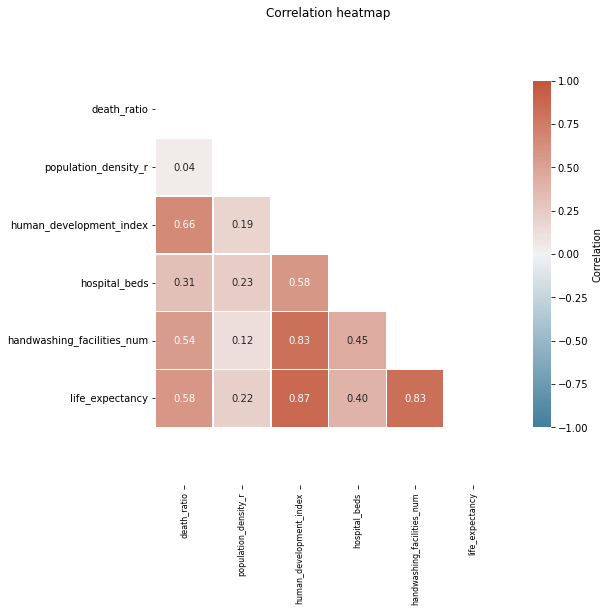

,death_ratio,population_density_r,human_development_index,hospital_beds,handwashing_facilities_num,life_expectancy
death_ratio,1.000000,0.043658,0.660201,0.314488,0.543674,0.581220
population_density_r,0.043658,1.000000,0.193456,0.228556,0.124904,0.216239
human_development_index,0.660201,0.193456,1.000000,0.575471,0.826457,0.871415
hospital_beds,0.314488,0.228556,0.575471,1.000000,0.446318,0.403532
handwashing_facilities_num,0.543674,0.124904,0.826457,0.446318,1.000000,0.834265
life_expectancy,0.581220,0.216239,0.871415,0.403532,0.834265,1.000000


In [19]:
import seaborn as sns

# sns.set_theme(style="white") 
df_corr = df.copy(deep=True)
df_corr['death_ratio'] = df_corr['total_deaths']/df_corr['population']
# df_corr['death_ratio'] = df_corr['total_deaths']
df_corr['hospital_beds'] = df_corr['hospital_beds_per_thousand']
df_corr['handwashing_facilities_num'] = (df_corr['handwashing_facilities'])/100
df_corr['population_density_r'] = df_corr['population_density']/df_corr['population']


r = df_corr[df_corr['location'] != 'World'].loc[:,['death_ratio', 'population_density_r', 'human_development_index', 'location',
              'hospital_beds', 'handwashing_facilities_num', 'life_expectancy']].dropna().groupby('location').max().reset_index().loc[:,[
              'death_ratio', 'population_density_r', 'human_development_index', 'location',
              'hospital_beds', 'handwashing_facilities_num', 'life_expectancy']]


corr = r.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, n=256, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=1, 
            vmin = -1,
            center=0,
            square=True, 
            linewidths=.5,
            annot = True,
            fmt='.2f', 
            annot_kws={'size': 10},
            cbar_kws={"shrink": .75, 'label': 'Correlation'})

plt.title('Correlation heatmap')
plt.tight_layout()
ax.tick_params(axis = 'x', labelsize = 8)
ax.set_ylim(len(corr)+1, -1)
# plt.savefig('corrTax.png', dpi = 600)

plt.show()

# sns.pairplot(r)

corr

- Here we use grouping by country and check the latest information of each country. To examine the relationship between variables, we need the latest information from each country. we use groupby with max.

- The number of deaths correlates positively with each of the other variables.

- The correlation of the population ratio per unit area and the number of deaths is a positive number very close to zero. That is, these variables do not have a strong linear relationship. Below in the scatter diagram, these two variables can be seen. A number of outlier have created a positive slope. If this correlation is significant, it means that the death rate increases with increasing population density. This is consistent with the high rate of transmission in the disease. To prevent the disease, the accumulation of people must be prevented.

- The correlation between the death rate and the development index is positive and close to one. That is, there is a strong and positive relationship between these two variables. This means that increasing human development increases the proportion of the dead. This can be due to the  stronger connection of the people for human and industrial development.

- There is a positive correlation between the number of hospital beds per person and the proportion of deaths. If this correlation is significant, This means that increasing the ratio of deaths to total increases the number of hospital beds. This is done to better respond to patients. By increasing the number of beds, they try to reduce the proportion of the death.

- There is a positive correlation between the availability of health facilities and the proportion of the dead. This means that increasing the ratio of deaths to total increases the availability of health facilities per person. This is done to increase prevention against the disease. With the increase in the availability of health facilities, efforts are being made to reduce the increase in the proportion of deaths.

- There is a positive correlation between life expectancy and death ratio. This means that increasing the average life expectancy increases the ratio of deaths to total. The reason for this is that these elderly people are weaker and have an underlying disease. Older people are more likely to die from the disease for these reasons. As the average life expectancy increases, the ratio of older people to the whole increases. This means that a larger proportion of people in the general population are more likely to die from the disease.

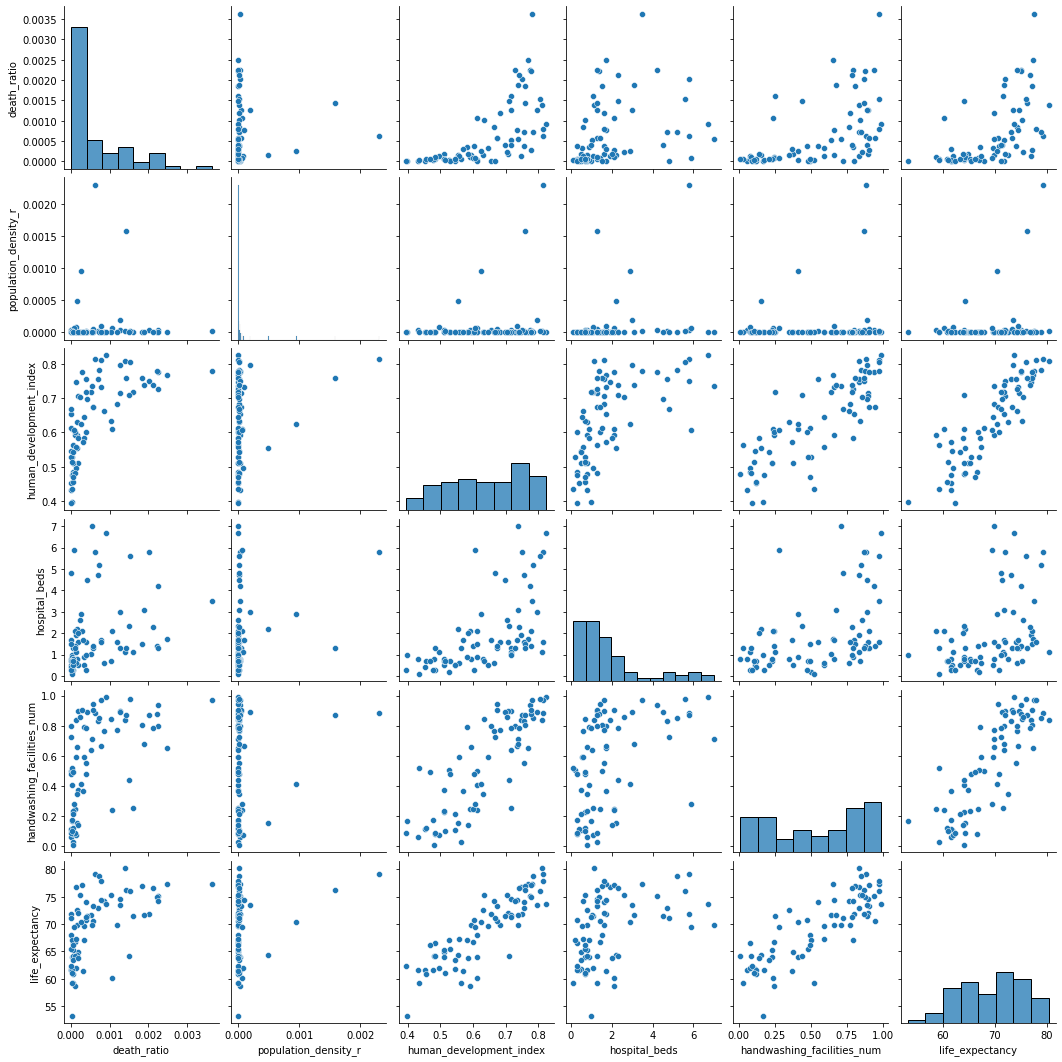

In [30]:
sns.pairplot(r);

## percent of vaccination

Here only the percentage value for each dose is important. The best way to display is to use text.

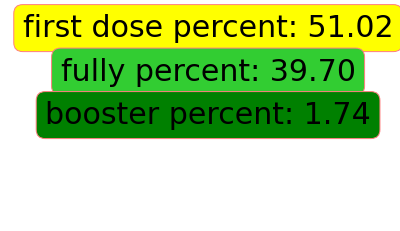

In [21]:
world_df = df[df['location'] == 'World'].copy(deep=True)
world_df.dropna(subset=['total_boosters','people_fully_vaccinated', 'people_vaccinated'], inplace=True)
world_df = world_df.iloc[-1]
booster_percent = world_df['total_boosters']/world_df['population']
fully_percent = world_df['people_fully_vaccinated']/world_df['population']
first_percent = world_df['people_vaccinated']/world_df['population']

plt.text(0.6, 0.9, "first dose percent: {:3.2f}".format(first_percent*100), size=30,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc='yellow',
                   )
         )
plt.text(0.6, 0.7, "fully percent: {:3.2f}".format(fully_percent*100), size=30,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc='limegreen',
                   )
         )
plt.text(0.6, 0.5, "booster percent: {:3.2f}".format(booster_percent*100), size=30,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc='green',
                   )
         )

plt.axis('off')
plt.show()

- To find this statistic, the latest available data on the number of injected doses have been used. records with nan in each of the corresponding columns are cleared. Some countries and world do not publish disease and vaccination statistics on a regular and daily basis. For this reason, there is a nan value for statistics for some days.

- As can be seen, only half of the world's population has received the first dose. We also see that only 40% of the world's population is fully vaccinated. This means that about half of the people in the world do not have access to or do not want the vaccine. A number of countries are poor and do not have access to vaccines. These statistics also point to this. These cases show that there is no equality in the distribution of vaccines. If we do not take into account the reluctance, statistics show that capitalist countries have access to a large number of vaccines so that they can have a third dose. This is at a time when poor countries do not have access to vaccines at all. The percentage of the third dose or booster is approximately equal to 2%.

## best and worst performance

Here only the name of countries and the percentage value for each country performance are important. The best way to display is to use text.

In [22]:
perfomance_df = df.groupby('location')[['total_deaths', 'population']].max()
perfomance_df['performance'] = perfomance_df['total_deaths']/perfomance_df['population']
perfomance_df.dropna(subset=['performance'], inplace=True)
worst_performance = perfomance_df.sort_values('performance', ascending=False)['performance'][0]
best_performance = perfomance_df.sort_values('performance', ascending=False)['performance'][-1]
best_list = perfomance_df[perfomance_df['performance']==best_performance].index
worst_list = perfomance_df[perfomance_df['performance']==worst_performance].index
worst_list, best_list

(Index(['Peru'], dtype='object', name='location'),
 Index(['Burundi'], dtype='object', name='location'))

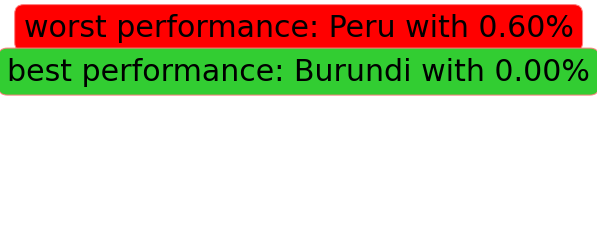

In [23]:
plt.text(0.6, 0.9, "worst performance: {} with {:3.2f}%".format(worst_list[0], worst_performance*100), size=30,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc='red',
                   )
         )
plt.text(0.6, 0.7, "best performance: {} with {:3.2f}%".format(best_list[0], best_performance*100), size=30,
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc='limegreen',
                   )
         )

plt.axis('off')
plt.show()

- Peru has the worst performance at 0.6%. Best performance for Burundi with almost 0% death rate. It is one of the poorest countries in the world and is located in Africa

- Burundi has low access to the vaccine and has vaccinated nearly zero percent of the total population. But Peru has already vaccinated its population and is much better in economical situation than Burundi. The economic situation makes it possible to use both the vaccine and better prevention by following the protocols. you can see vaccination ratio and economical situation of countries in "vaccination ratio and gdp relation". Here you see that the poorer country performed better than the richer country. At the same time, more capital will allow for better vaccination and compliance with protocols. This misconduct could be due to the neglect of the Peruvian people and government to the disease and its protocols in the past. Of course, the performance of this country in vaccination shows that now the people of this country have paid more attention to this disease. The reason for the good performance of the African country can be its low connection with other countries and the natural social distance in this country. This means that the culture of the people in this country may be such that people have little contact with each other. This low communication of people may have caused this performance. Low communication with abroad makes the transmission of the disease inside the country very unlikely. Of course, the reason for this statistic may be the lack of accurate reports of corona deaths. The reason could be the weak medical system of this country.

## vaccin impact on death

selected countries

- country with high population
- Industrialized countries

in second group, people are on street for working and have high contacts in a period of time.

population is a confunding variable. ratio of vaccination and ratio of death are two variable without confunding variable. we use these two ratio in this part.

Some countries do not publish disease and vaccination statistics on a regular and daily basis. For this reason, there is a nan value for statistics for some days.
nan values is not important. we want to ignore them. matplotlib do not show them. 



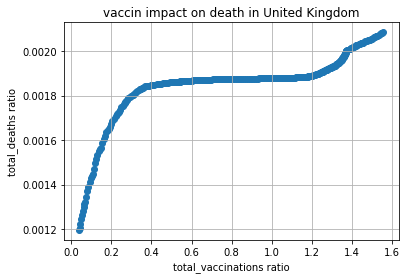

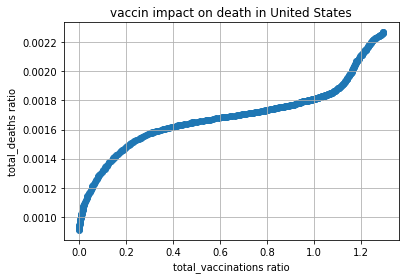

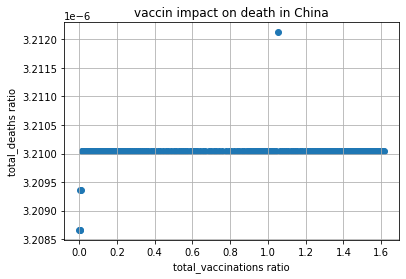

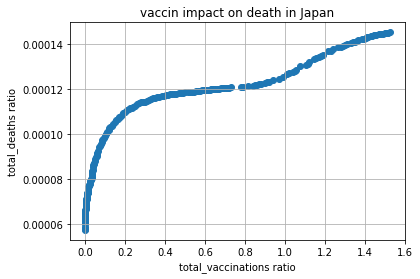

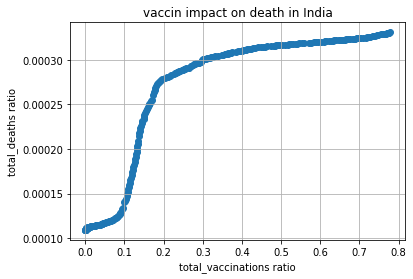

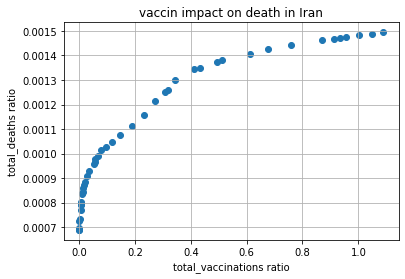

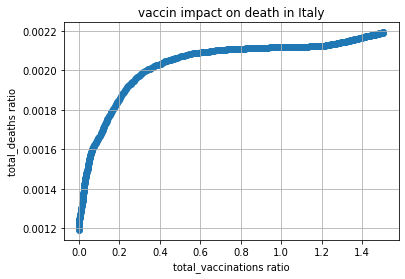

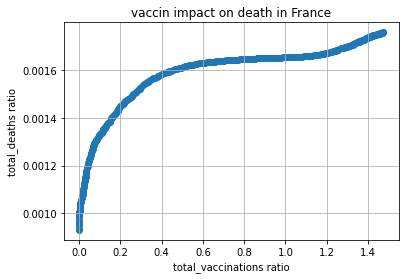

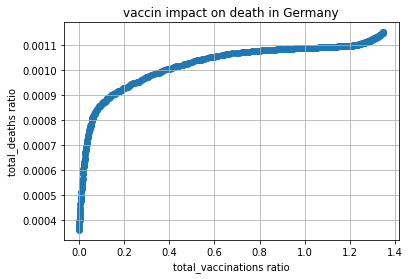

In [24]:
countries = ['United Kingdom', 'United States','China', 'Japan', 'India', 'Iran', 'Italy', 'France', 'Germany']
for country in countries:
  uk_df = df[df['location'] == country] 
  plt.scatter(uk_df['total_vaccinations']/uk_df['population'], uk_df['total_deaths']/uk_df['population'])
  plt.xlabel('total_vaccinations ratio')
  plt.ylabel('total_deaths ratio')
  plt.title('vaccin impact on death in {}'.format(country))
  # plt.xlim(0,2)
  # plt.ylim(0, 0.0035)
  plt.grid()
  plt.show()

- Here we want to show relation of two variable for each countries. The best way to display is to use scatterplot for each countries.

- In the United Kingdom, the rate of deaths has slowed after 0.2 people were vaccinated at least once. After 0.6 people have taken at least one dose, the proportion of deaths to total has stopped growing. This can be seen as constant plot. The plot at the end after vaccination of the whole population with at least one dose is ascending. But its inclination is very different from before vaccination. With an increase in the percentage of vaccination, the percentage of deaths increases less than before vaccination. This demonstrates the effectiveness of vaccination in controlling infection and death. The last increase in the plot is due to non-compliance with protocols. Because by injecting the vaccine completely, people can still get Corona. But vaccination reduces the risk of death. A reduction in the final slope indicates this. The plot rose again when most people took one dose and a significant percentage received the second dose. This increase may indicate that the protocols are not followed due to vaccination.

- In the United states, the rate of deaths has slowed after 0.2 people were vaccinated at least once. After 0.8 people have taken at least one dose, the proportion of deaths to total has stopped growing. This can be seen as constant plot. The plot at the end after vaccination of the whole population with at least one dose is ascending. But its inclination is very different from before vaccination. With an increase in the percentage of vaccination, the percentage of deaths increases less than before vaccination. This demonstrates the effectiveness of vaccination in controlling infection and death. The last increase in the plot is due to non-compliance with protocols. Because by injecting the vaccine completely, people can still get Corona. But vaccination reduces the risk of death. A reduction in the final slope indicates this. The plot rose again when most people took one dose. This increase may indicate that the protocols are not followed due to vaccination.

- In japan, the rate of deaths has slowed after 0.2 people were vaccinated at least once. After 0.6 people have taken at least one dose, the proportion of deaths to total has stopped growing. This can be seen as constant plot. The plot at the end after vaccination of the whole population with at least one dose is ascending. But its inclination is very different from before vaccination. With an increase in the percentage of vaccination, the percentage of deaths increases less than before vaccination. This demonstrates the effectiveness of vaccination in controlling infection and death. The last increase in the plot is due to non-compliance with protocols. Because by injecting the vaccine completely, people can still get Corona. But vaccination reduces the risk of death. A reduction in the final slope indicates this. The plot rose again when most people took one dose. This increase may indicate that the protocols are not followed due to vaccination.

- In india, the rate of deaths has slowed after 0.2 people were vaccinated at least once. After 0.6 people have taken at least one dose, the proportion of deaths to total has stopped growing. This can be seen as constant plot. The plot at the end after vaccination of the whole population with at least one dose is ascending very slow. But its inclination is very different from before vaccination. With an increase in the percentage of vaccination, the percentage of deaths increases less than before vaccination. This demonstrates the effectiveness of vaccination in controlling infection and death. The last increase in the plot is due to non-compliance with protocols. Because by injecting the vaccine completely, people can still get Corona. But vaccination reduces the risk of death. A reduction in the final slope indicates this. This increase may indicate that the protocols are not completely followed due to vaccination. Of course, in this country, injectable vaccines have not yet reached the general population. So this increase could be due to the lack of complete vaccination of a large number of people. Because one dose does not provide sufficient resistance to infection.

- In china, The plot is constant. That is, the ratio of deaths to total has remained constant with the increase in vaccinated individuals. Vaccination did not appear to have any effect on the ratio of deaths in total. The proportion of deaths to the total is very low, almost zero. This means that in this country, the protocols are fully and strictly observed. Very few people have died due to proper compliance with the protocols. For this reason, the number of deaths has been constant for a long time. Increasing the number of people vaccinated has helped to prevent better and stronger disease. The vaccine has strengthened compliance with protocols. Vaccination has made it possible to keep statistics steady.

- In iran, the rate of deaths has slowed after 0.2 people were vaccinated at least once. After 0.8 people have taken at least one dose, the proportion of deaths to total has stopped growing. This can be seen as constant plot. The plot at the end after vaccination of the whole population with at least one dose is ascending. But its inclination is very different from before vaccination. With an increase in the percentage of vaccination, the percentage of deaths increases less than before vaccination. This demonstrates the effectiveness of vaccination in controlling infection and death. The last increase in the plot is due to non-compliance with protocols. Because by injecting the vaccine completely, people can still get Corona. But vaccination reduces the risk of death. A reduction in the final slope indicates this. The plot rose again when most people took one dose. This increase may indicate that the protocols are not followed due to vaccination.

- In italy, the rate of deaths has slowed after 0.2 people were vaccinated at least once. After 0.8 people have taken at least one dose, the proportion of deaths to total has stopped growing. This can be seen as constant plot. The plot at the end after vaccination of the whole population with at least one dose is ascending. But its inclination is very different from before vaccination. With an increase in the percentage of vaccination, the percentage of deaths increases less than before vaccination. This demonstrates the effectiveness of vaccination in controlling infection and death. The last increase in the plot is due to non-compliance with protocols. Because by injecting the vaccine completely, people can still get Corona. But vaccination reduces the risk of death. A reduction in the final slope indicates this. The plot rose again when most people took one dose and a significant percentage received the second dose. This increase may indicate that the protocols are not followed due to vaccination.

- In france, the rate of deaths has slowed after 0.2 people were vaccinated at least once. After 0.8 people have taken at least one dose, the proportion of deaths to total has stopped growing. This can be seen as constant plot. The plot at the end after vaccination of the whole population with at least one dose is ascending. But its inclination is very different from before vaccination. With an increase in the percentage of vaccination, the percentage of deaths increases less than before vaccination. This demonstrates the effectiveness of vaccination in controlling infection and death. The last increase in the plot is due to non-compliance with protocols. Because by injecting the vaccine completely, people can still get Corona. But vaccination reduces the risk of death. A reduction in the final slope indicates this. The plot rose again when most people took one dose and a significant percentage received the second dose. This increase may indicate that the protocols are not followed due to vaccination.

- In germany, the rate of deaths has slowed after 0.2 people were vaccinated at least once. After 0.8 people have taken at least one dose, the proportion of deaths to total has stopped growing. This can be seen as constant plot. The plot at the end after vaccination of the whole population with at least one dose is ascending. But its inclination is very different from before vaccination. With an increase in the percentage of vaccination, the percentage of deaths increases less than before vaccination. This demonstrates the effectiveness of vaccination in controlling infection and death. The last increase in the plot is due to non-compliance with protocols. Because by injecting the vaccine completely, people can still get Corona. But vaccination reduces the risk of death. A reduction in the final slope indicates this. The plot rose again when most people took one dose and a significant percentage received the second dose. This increase may indicate that the protocols are not followed due to vaccination.

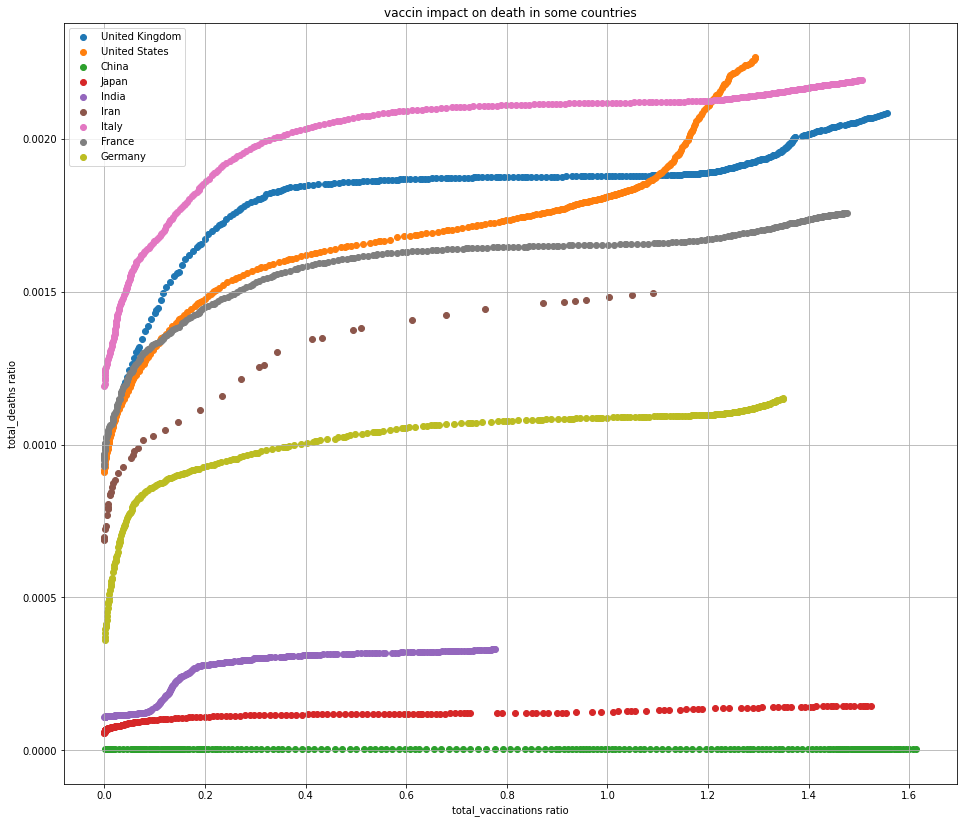

In [25]:
countries = ['United Kingdom', 'United States','China', 'Japan', 'India', 'Iran', 'Italy', 'France', 'Germany']
plt.figure(figsize=(16,14))
for country in countries:
  uk_df = df[df['location'] == country] 
  plt.scatter(uk_df['total_vaccinations']/uk_df['population'], uk_df['total_deaths']/uk_df['population'], label=country)
plt.xlabel('total_vaccinations ratio')
plt.ylabel('total_deaths ratio')
plt.title('vaccin impact on death in some countries')
# plt.ylim(0, 0.0035)
plt.grid()
plt.legend()
plt.show()

- Above we can see and compare the relationship between vaccination ratio and death rate in different countries. As can be seen, in all countries, with the increase in the ratio of vaccinations to total, the growth rate of the ratio of death to total has slowed down. The death rate has gone steady. This trend reflects the effectiveness of vaccination in controlling death and infection. The only difference between the graphs is the value of y, in which they are constant. These values ​​refer to the performance of countries in dealing with the disease. The final growth in the charts shows that vaccination alone cannot reduce the number of infections to zero. For this to happen, protocols must continue to be followed.

## vaccination ratio and gdp relation

- total_vaccinations is dependent to population. ratio of total_vaccinations is not dependent. with this work, we remove population impact on vaccination as a confunding variable. nan values is not important. we want to ignore them.

- The best way to show the relationship between two variables is to use a scatter plot.

In [26]:
import plotly.express as px

vaccin_gdp_df = df.groupby('location')[['total_vaccinations', 'population', 'gdp_per_capita']].max().reset_index()
vaccin_gdp_df['total_vaccinations_ratio'] = (vaccin_gdp_df['total_vaccinations']/vaccin_gdp_df['population'])
vaccin_gdp_df['Iran'] = (vaccin_gdp_df['location']=='Iran').astype(str)
vaccin_gdp_df.dropna(subset=['total_vaccinations', 'population', 'gdp_per_capita'], inplace=True)
fig = px.scatter(vaccin_gdp_df, x='gdp_per_capita', y='total_vaccinations_ratio',
                 color='Iran', hover_data=['location'], color_continuous_scale='Bluered_r',
                 labels={'x': 'gdp', 'y': 'total_vaccinations/population'},
                 title='vaccination ratio and gdp relation') #size='population', 
fig.show()

In [27]:
vaccin_gdp_df.isna().sum()

location                    0
total_vaccinations          0
population                  0
gdp_per_capita              0
total_vaccinations_ratio    0
Iran                        0
dtype: int64

- Here we use data grouping by country to get the total number of vaccines in a country and the latest gdp value. For each country's records, we consider the maximum amount of gdp and vaccine injected.

- As can be seen above, most countries with a GDP of more than 20k have already vaccinated more than their population.

- Most countries with a GDP of less than 20k have been vaccinated less than their own population. It can also be seen that most of these countries have vaccinated less than half of their population.

- These cases show the relationship between the amount of capital and the ratio of the vaccine injected. The more capital a country has, the more people can be vaccinated.

- iran is a red circle in plot. Iran has a GDP of less than 20k but has been able to inject more vaccines than its own population. Comparing Iran with countries with gdp less than 20k, we can see that Iran's performance has been good. Iran has been one of the countries that has been able to vaccinate more than its population during this gdp period.

- It shows that richer countries can provide better conditions for prevention. This shows that the corona affects the rich and the poor differently. The disease does more harm to the poor, and it does not treat people equally.

## show death ratio on map

total_deaths show all deaths in a country before a day. max value of total_deaths for all records of a country is all deaths in a country till now. nan value is ignored for total_deaths.

In [28]:
import plotly.express as px

death_ratio_df = df.groupby('location')[['total_deaths', 'population', 'iso_code']].max().reset_index()
death_ratio_df = death_ratio_df[death_ratio_df['location']!='World']
death_ratio_df['total_deaths_ratio'] = (death_ratio_df['total_deaths']/death_ratio_df['population'])

fig = px.choropleth(death_ratio_df, locations="iso_code",
                    color="total_deaths_ratio", # lifeExp is a column of gapminder
                    hover_name="location", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

- As can be seen on the map, Peru had the worst ratio of deaths to the total. The highlight of the map is the blue color of most African countries. This means that in these countries the ratio of deaths to the total has been very low and close to zero.

- The reason for the good performance of the African countries can be their low connection with other countries and the natural social distance in these countries. This means that the culture of the people in these countries may be such that people have little contact with each other. This low communication of people may have caused this performance. Low communication with abroad makes the transmission of the disease inside the country very unlikely. Of course, the reason for this statistic may be the lack of accurate reports of corona deaths. The reason could be the weak medical system of these countries.

- South American countries have near-yellow colors. It shows that these countries have not performed well and a large proportion of the people in these countries have died.

- In Europe, especially in Eastern Europe and southern countries, poor performance is seen. That is why the color of the areas is close to yellow. In Europe as a whole, few countries are close to the blue and have outperformed their neighbors. There has also been no excellent performance in the United Kingdom and the United States.

- India, China and Australia are also blue and a small proportion of the population has died. There is good performance in populous countries like China and India. This is while a country like India is not in a good position in terms of wealth distribution. Many people in this country are in poverty. Given the high infectivity of the disease, this result is remarkable.

- In capitalist countries, performance has not been excellent. Capital helps with vaccination and prevention. Given this, the performance of these countries is remarkable.

## all vaccination and population on map

total_vaccinations show all vaccinations in a country before a day. max value of total_vaccinations for all records of a country is all vaccinations in a country till now. nan value is ignored for total_vaccinations.

In [29]:
import plotly.express as px

vaccination_df = df.groupby('location')[['total_vaccinations', 'population', 'iso_code']].max().reset_index()
vaccination_df = vaccination_df[vaccination_df['location']!='World']
# vaccination_ratio_df['total_vaccinations_ratio'] = (vaccination_ratio_df['total_vaccinations']/vaccination_ratio_df['population'])

fig = px.choropleth(vaccination_df, locations="iso_code",
                    color="total_vaccinations", # lifeExp is a column of gapminder
                    hover_name="location",
                    hover_data=["population"], # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

- All countries except India and China are blue. Apart from these two countries, other countries have a population of much less than 1 billion people. If these countries vaccinate all people with two doses, the number of vaccines will not reach one billion. For this reason, all countries except these two countries have almost the same color and there is no difference between them.

- The reason for this show is that we used the number of vaccines to color the map. If we used the ratio of vaccines to the total population in each country, the colors of the countries would be more different.

## compare choropleth and geographical scatter plot

- choropleth is good for show rates on map and compare rate of diffrent places.
- Choropleths are often not suitable for showing total values.
- in Choropleths, It can be difficult to distinguish between different color in sequential color bar and for different shapes.

- geographical scatter plot is suitable for showing total values.
- geographical scatter plot is not suitable for showing rates.
- Choropleths is good for q6
- geographical scatter plot is good for q7

## vaccination impact on covid-19

- we use q4 plot in second part of HW. vaccin impact on death

- selected countries

> - country with high population
> - Industrialized countries

- in second group, people are on street for working and have high contacts in a period of time.

- population is a confunding variable. ratio of vaccination and ratio of death are two variable without confunding variable. we use these two ratio in this part.

- We can see and compare the relationship between vaccination ratio and death rate in different countries. As can be seen, in all countries, with the increase in the ratio of vaccinations to total, the growth rate of the ratio of death to total has slowed down. The death rate has gone steady. This trend reflects the effectiveness of vaccination in controlling death and infection. The only difference between the graphs is the value of y, in which they are constant. These values ​​refer to the performance of countries in dealing with the disease. The final growth in the charts shows that vaccination alone cannot reduce the number of infections to zero. For this to happen, protocols must continue to be followed.

- In countries, the rate of deaths has slowed after 0.2 people were vaccinated at least once. After 0.8 people have taken at least one dose, the proportion of deaths to total has stopped growing. This can be seen as constant plot. The plot at the end after vaccination of the whole population with at least one dose is ascending. But its inclination is very different from before vaccination. With an increase in the percentage of vaccination, the percentage of deaths increases less than before vaccination. This demonstrates the effectiveness of vaccination in controlling infection and death. The last increase in the plot is due to non-compliance with protocols. Because by injecting the vaccine completely, people can still get Corona. But vaccination reduces the risk of death. A reduction in the final slope indicates this. The plot rose again when most people took one dose and a significant percentage received the second dose. This increase may indicate that the protocols are not followed due to vaccination.

- The ratio of fully vaccinated individuals to total individuals is effective in inhibiting covid-19. It does not matter how fast we reach this level.

## predict next peak in iran

- we use q1 plot in part one of HW. case, death and vaccination over time in iran

- Increasing the incidence is considered the beginning of a peak. We know that after the peak of infection, the peak of death begins after a while. Therefore, examining the time of death peaks, which are more obvious, is enough to examine the approximate time of occurrence of infection peaks. As can be seen, the distance between the two peaks after the second peak is at least one month and at most two months. The first peak and its distance from the second peak can not be examined. Because there were no new versions of the disease at that time. There was also little information about the disease and how to diagnose it. In this situation, we had a long vacation and jobs were closed. These cases have affected the observance of protocols. The maximum distance between the two peaks in the desired period is related to the beginning of April, when there is a holiday in the country. In this case, the work is closed. This holiday has caused a two-month gap between the peaks. So the distance between the peaks is usually one month. At the bottom of the morbidity and death charts, we see the end of a peak, which is the fifth peak. Given the usual distance of peaks in Iran, it can be predicted that the incidence will increase in mid-December. And a new peak will be started. Vaccination does not completely prevent the infection. To reduce the incidence and mortality to a high level, we need a high percentage of people to be fully vaccinated. Full compliance with the protocols is also required. So if the process of compliance with the protocols continues as before, we will see a new peak in mid-December. The only difference is that vaccination causes the peak value to drop.